# Written Assignment
## Candidate name: Juan Pablo Herrera
### Question 1 - PLMS Reviews

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Read Data

In [2]:
# Read data
cases = pd.read_csv('csv/1_case_table-csv.csv')

audit_prev = pd.read_csv('csv/2_case_audit_prev-csv.csv')
audit_curr = pd.read_csv('csv/3_case_audit_current-csv.csv')
audit = pd.concat([audit_prev, audit_curr]).assign(OPERATION_DATE = lambda x: pd.to_datetime(x.OPERATION_DATE))

services = pd.read_csv('csv/4_srvreq_table-csv.csv')
services = services.assign(REVIEW_START_DATE = lambda x: pd.to_datetime(x.REVIEW_START_DATE),
                         REVIEW_CLOSED_DATE = lambda x: pd.to_datetime(x.REVIEW_CLOSED_DATE))

# Question a
When cheque production is turned off because of a PLMS file review:   
**We assume that an event happen because of a PLMS file review if the update is done while the review is still open.**

In [3]:
# Instances logged during review
updates_during_review = (services.query('REVIEW_TYPE == "PLMS Review"')
    .merge(
        audit,
        on = 'CASE_ID',
        how = 'inner'
    )
    .query('OPERATION_DATE.between(REVIEW_START_DATE, REVIEW_CLOSED_DATE)')    
)

# Cases that stopped cheque production
cases_cheque_stop = updates_during_review.query('FIELD == "Chq Prod Flag" and VALUE_NEW == "N"').CASE_ID

# in how many instances cases close?
closed_cases = updates_during_review.query('FIELD == "Status" and VALUE_NEW == "Closed" and CASE_ID in @cases_cheque_stop') # ESte es el bueno
print('In how many instances do cases close?')
print(f'Instances that closed the case: {closed_cases.shape[0]}')
print(' ')

# How many times do cases (and within what time frame) result in cheque production being turned back on? Present the time frame as range, mean and median days.
reopened_cases = (updates_during_review
    .sort_values('OPERATION_DATE')
    .query('FIELD == "Chq Prod Flag"')
    .assign(
        REOPEN_VALUE = lambda x: x.groupby(['S_ID', 'CASE_ID']).VALUE_NEW.shift(-1),
        REOPEN_DATE = lambda x: x.groupby(['S_ID', 'CASE_ID']).OPERATION_DATE.shift(-1),
        days_to_reopen = lambda x: (x.REOPEN_DATE - x.OPERATION_DATE).dt.days)
    .query('VALUE_OLD == "Y" and VALUE_NEW == "N" and REOPEN_VALUE == "Y" and CASE_ID in @cases_cheque_stop')
)
print('How many times do cases (and within what timeframe) result in cheque production being turned back on?')
print(f'Times that cheque production was turned back on during the PLMS review: {reopened_cases.shape[0]}')
print(f'Mean reopen time: {reopened_cases.days_to_reopen.mean()}')
print(f'Median reopen time: {reopened_cases.days_to_reopen.median()}')
print(f'Range reopen time: ({reopened_cases.days_to_reopen.min()}, {reopened_cases.days_to_reopen.max()})')
print(' ')

# How many files with cheque production off do not end up closing?
cases_not_closed = updates_during_review.query('CASE_ID in @cases_cheque_stop and CASE_ID not in @closed_cases').CASE_ID.nunique()
print('How many files with cheque production off do not end up closing?')
print(f'Times that cheque production stopped and file didnt close: {cases_not_closed}')

In how many instances do cases close?
Instances that closed the case: 147
 
How many times do cases (and within what timeframe) result in cheque production being turned back on?
Times that cheque production was turned back on during the PLMS review: 553
Mean reopen time: 30.009041591320074
Median reopen time: 20.0
Range reopen time: (0.0, 212.0)
 
How many files with cheque production off do not end up closing?
Times that cheque production stopped and file didnt close: 1722


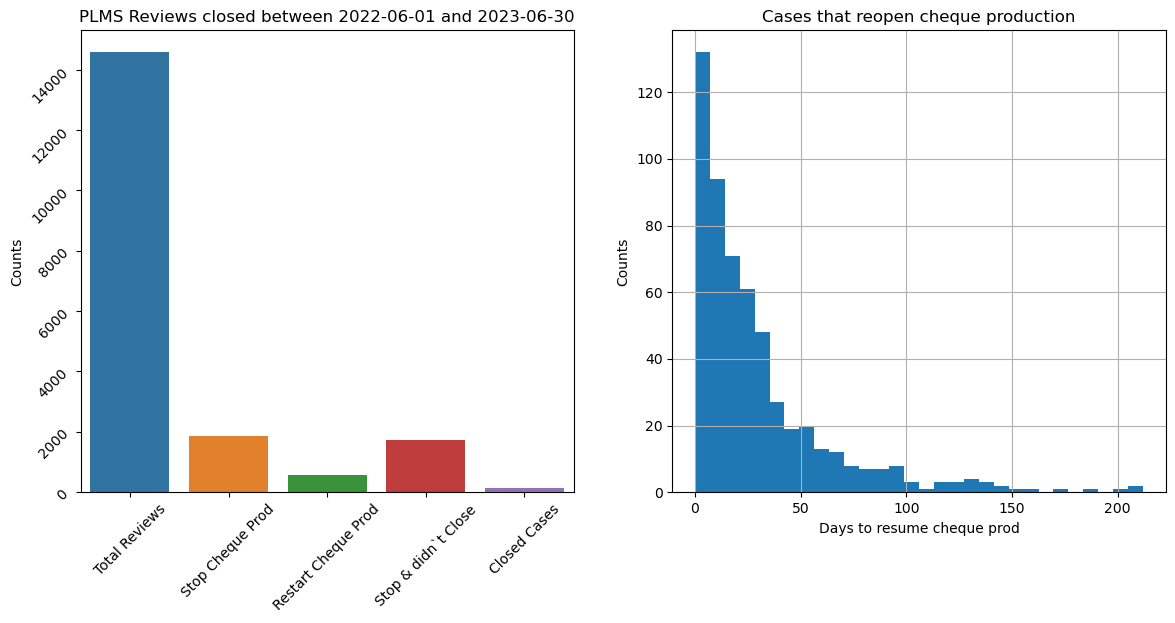

In [4]:
# Generate plot
fig, ax = plt.subplots(1,2, figsize = (14,6))
totals_df = pd.DataFrame({'Total Reviews' : services.loc[(services.REVIEW_CLOSED_DATE > audit.OPERATION_DATE.min()) & (services.REVIEW_CLOSED_DATE < audit.OPERATION_DATE.max()) & (services.REVIEW_TYPE == "PLMS Review")].shape[0],
              'Stop Cheque Prod': len(cases_cheque_stop),
              'Restart Cheque Prod':reopened_cases.shape[0],
              'Stop & didn`t Close':cases_not_closed,
              'Closed Cases':closed_cases.shape[0],
              
              
              }, index = [0])

sns.barplot(data = totals_df, ax = ax[0])
ax[0].tick_params(labelrotation=45)
ax[0].set_ylabel('Counts')
ax[0].set_title(f'PLMS Reviews closed between {audit.OPERATION_DATE.min().date()} and {audit.OPERATION_DATE.max().date()}')

reopened_cases.days_to_reopen.hist(bins = 30, ax = ax[1])
ax[1].set_xlabel("Days to resume cheque prod")
ax[1].set_ylabel("Counts")
ax[1].set_title('Cases that reopen cheque production')

plt.show()

# Question b
When a file is closed because of a PLMS review:   
**We assume that an event happen because of a PLMS file review if the update is done while the review is still open.**

How long does the file remain closed?
Mean reopen time: 80.41463414634147
Median reopen time: 67.0
Range reopen time: (0.0, 296.0)
 
How many files are reopened with 60, 90 and 180?
Files reopened within 60 days: 38
Files reopened within 90 days: 51
Files reopened within 180 days: 74


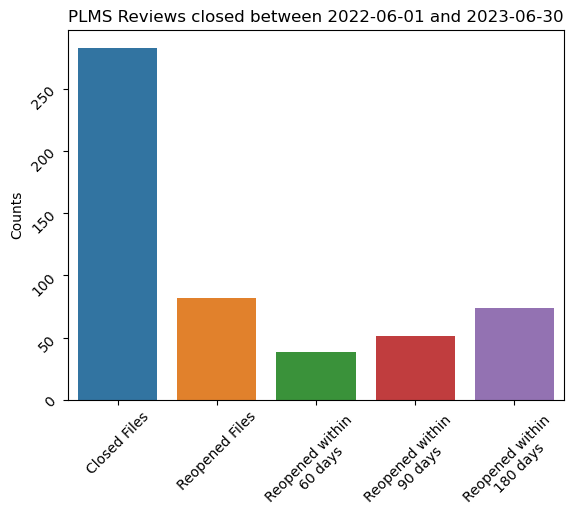

In [5]:
# b. When a file is closed because of a PLMS review:
closed_cases_during_review = (
    services
    .query('REVIEW_TYPE == "PLMS Review"')
    .merge(
        audit,
        on = 'CASE_ID',
        how = 'inner'
    )
    .query('OPERATION_DATE.between(REVIEW_START_DATE, REVIEW_CLOSED_DATE) and FIELD == "Status" and VALUE_NEW == "Closed" ')
    .CASE_ID
    .unique()   
)


#i. How long does the file remain closed?
reopened_files = (audit
    .query('CASE_ID in @closed_cases_during_review and FIELD == "Status"')
    .sort_values('OPERATION_DATE')
    .assign(
        REOPEN_VALUE = lambda x: x.groupby(['CASE_ID']).VALUE_NEW.shift(-1),
        REOPEN_DATE = lambda x: x.groupby(['CASE_ID']).OPERATION_DATE.shift(-1),
        days_to_reopen = lambda x: (x.REOPEN_DATE - x.OPERATION_DATE).dt.days)
    .query('VALUE_NEW == "Closed" and REOPEN_VALUE.notna()', engine = "python")
)

print('How long does the file remain closed?')
print(f'Mean reopen time: {reopened_files.days_to_reopen.mean()}')
print(f'Median reopen time: {reopened_files.days_to_reopen.median()}')
print(f'Range reopen time: ({reopened_files.days_to_reopen.min()}, {reopened_files.days_to_reopen.max()})')
print(' ')
#ii. How many files are reopened within 2 months (60 days)?
q = "Files reopened within {days} days: {num_files}"
day_to_check = [60, 90, 180]

print('How many files are reopened with 60, 90 and 180?')
_ = [print(q.format(days = d, num_files = reopened_files.query('days_to_reopen <= @d').shape[0])) for d in day_to_check]
dict_open_days = {f"Reopened within \n{d} days" : reopened_files.query('days_to_reopen <= @d').shape[0] for d in day_to_check}

totals_df = pd.DataFrame({
              'Closed Files': len(closed_cases_during_review),
              'Reopened Files':reopened_files.shape[0],
              **dict_open_days,
              }, index = [0])

sns.barplot(data = totals_df)
plt.tick_params(labelrotation=45)
plt.ylabel('Counts')
plt.title(f'PLMS Reviews closed between {audit.OPERATION_DATE.min().date()} and {audit.OPERATION_DATE.max().date()}')
plt.show()
